Import all necessary modules

In [2]:
import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import data_utils as du
import model_utils as mu
import ols_utils as ols

print("Python modules imported succesfully")

Python modules imported succesfully


Load the data
The columns in the data consist of hourly average ambient variables:
 - Temperature (T) in the range 1.81°C to 37.11°C,
 - Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
 - Relative Humidity (RH) in the range 25.56% to 100.16%
 - Exhaust Vacuum (V) in the range 25.36-81.56 cm Hg
 - Net hourly electrical energy output (PE) 420.26-495.76 MW (Target we are trying to predict) 

and add heat-index as a new feature
see National Oceanic and Atmospheric Administration (NOAA) and its Weather Prediction Center (www.wpc.ncep.noaa.gov)

In [3]:
# Load the data
data = du.load_data()

# add heat-index as a new feature
data['HI'] = du.calculate_heat_index(data['AT'], data['RH'])      

#first 5 rows of the dataset with the new feature
print(data.head(5))


First 5 rows of data:
      AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90

Loaded data:
          AT      V       AP     RH      PE
0     14.96  41.76  1024.07  73.17  463.26
1     25.18  62.96  1020.04  59.08  444.37
2      5.11  39.40  1012.16  92.14  488.56
3     20.86  57.32  1010.24  76.64  446.48
4     10.82  37.50  1009.23  96.62  473.90
...     ...    ...      ...    ...     ...
9563  16.65  49.69  1014.01  91.00  460.03
9564  13.19  39.18  1023.67  66.78  469.62
9565  31.32  74.33  1012.92  36.48  429.57
9566  24.48  69.45  1013.86  62.39  435.74
9567  21.60  62.52  1017.23  67.87  453.28

[9568 rows x 5 columns]
      AT      V       AP     RH      PE          HI
0  14.96  41.76  1024.07  73.17  463.26  275.468466
1  25.18  62.96  1020.04  59.08  444.37  195.034349
2   5.11  39.40  1012.16 

Analyse the data and print following diagrams:
- Distribution Histogram of Features
- Scattered plot for each pair of features
- Correlation Matrix - HeatMap


Distribution of dataset:
                AT            V           AP           RH           PE  \
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000   
mean     19.651231    54.305804  1013.259078    73.308978   454.365009   
std       7.452473    12.707893     5.938784    14.600269    17.066995   
min       1.810000    25.360000   992.890000    25.560000   420.260000   
25%      13.510000    41.740000  1009.100000    63.327500   439.750000   
50%      20.345000    52.080000  1012.940000    74.975000   451.550000   
75%      25.720000    66.540000  1017.260000    84.830000   468.430000   
max      37.110000    81.560000  1033.300000   100.160000   495.760000   

                HI  
count  9568.000000  
mean    240.823205  
std      58.379786  
min     100.886634  
25%     194.329472  
50%     230.695371  
75%     286.932419  
max     395.716914  


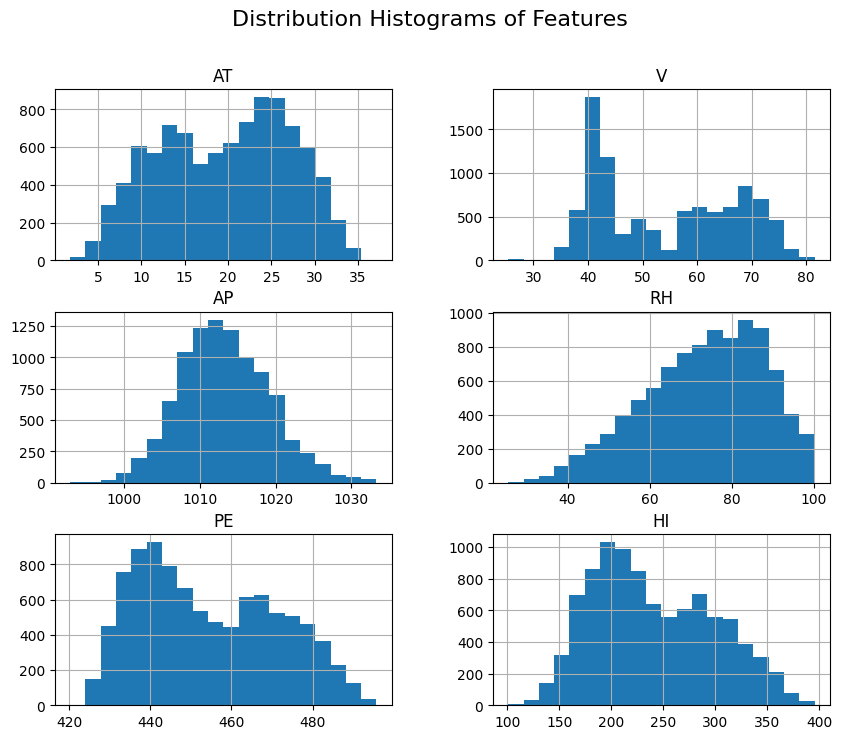

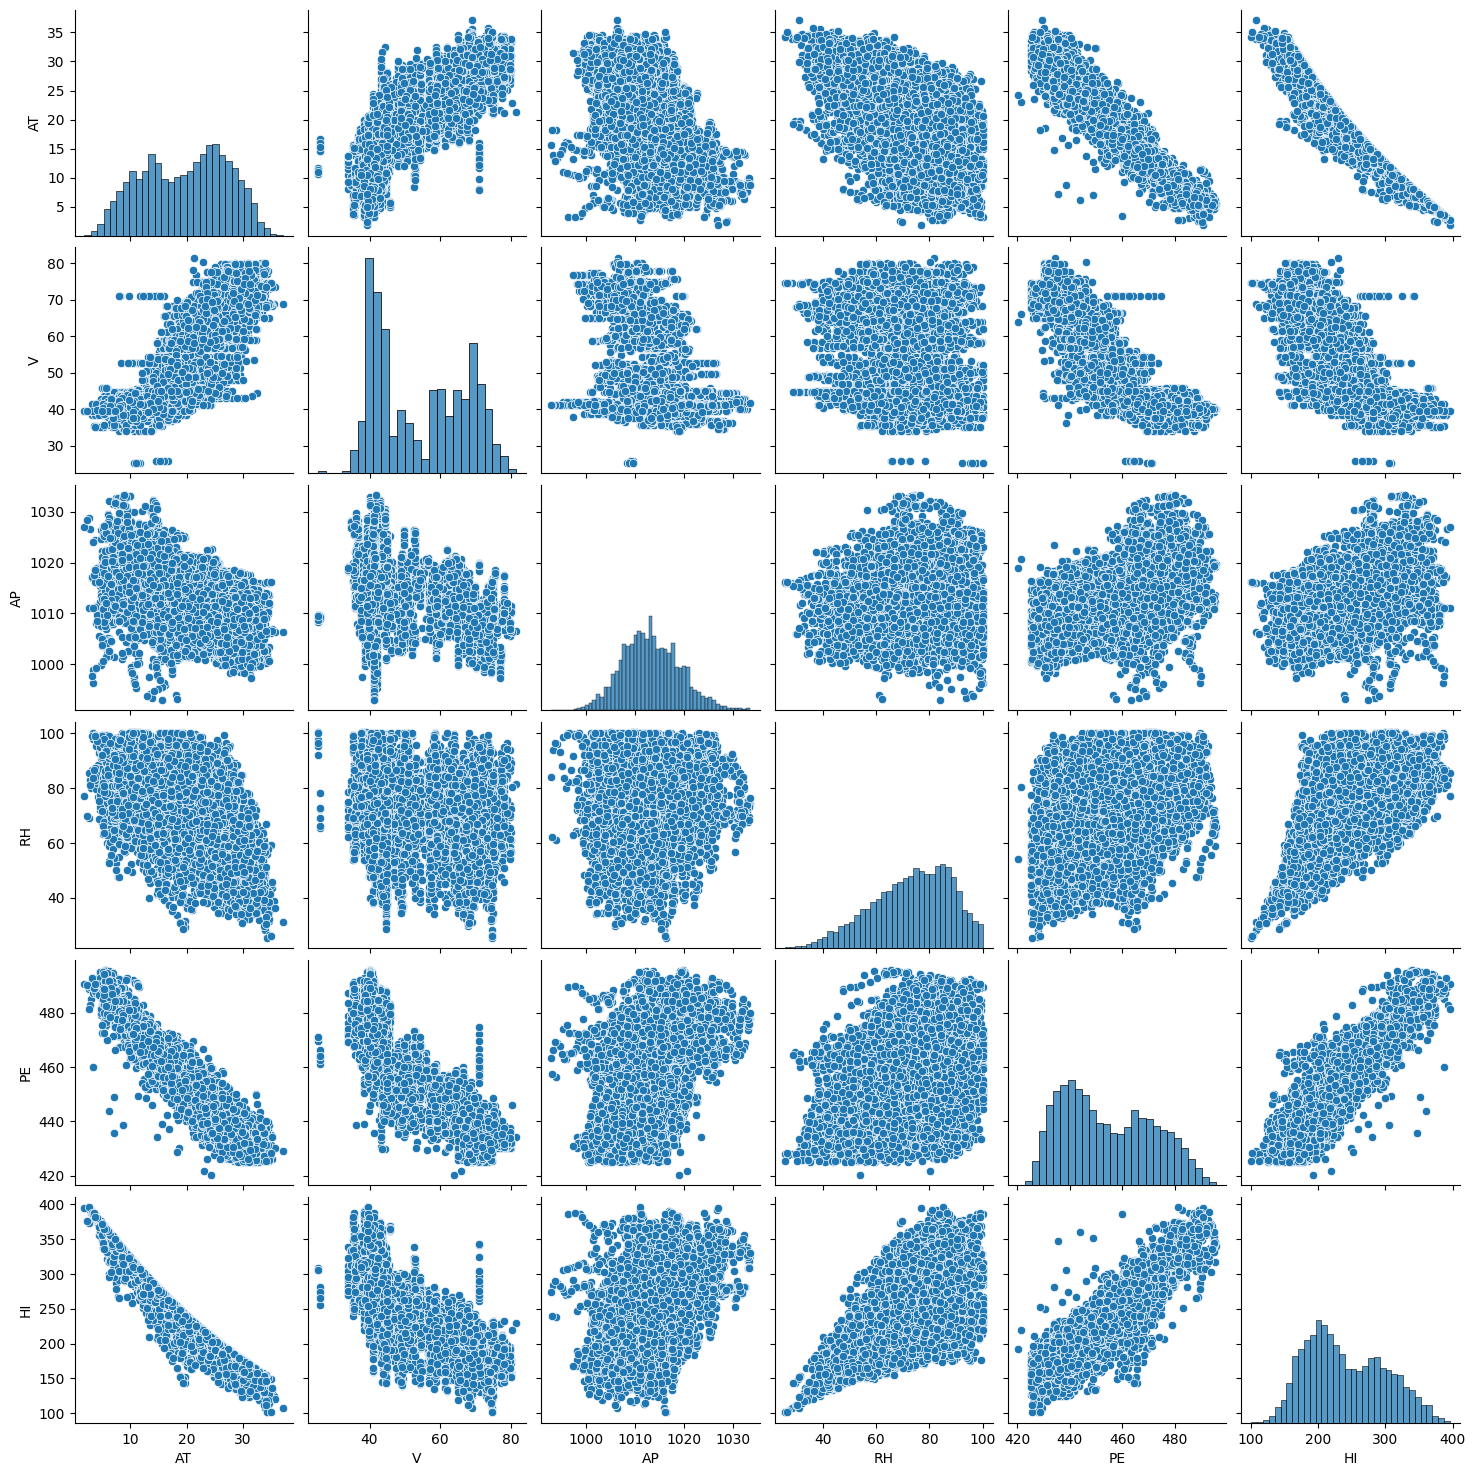


Data correlation matrix:
          AT         V        AP        RH        PE        HI
AT  1.000000  0.844107 -0.507549 -0.542535 -0.948128 -0.979916
V   0.844107  1.000000 -0.413502 -0.312187 -0.869780 -0.797436
AP -0.507549 -0.413502  1.000000  0.099574  0.518429  0.477907
RH -0.542535 -0.312187  0.099574  1.000000  0.389794  0.627475
PE -0.948128 -0.869780  0.518429  0.389794  1.000000  0.921185
HI -0.979916 -0.797436  0.477907  0.627475  0.921185  1.000000


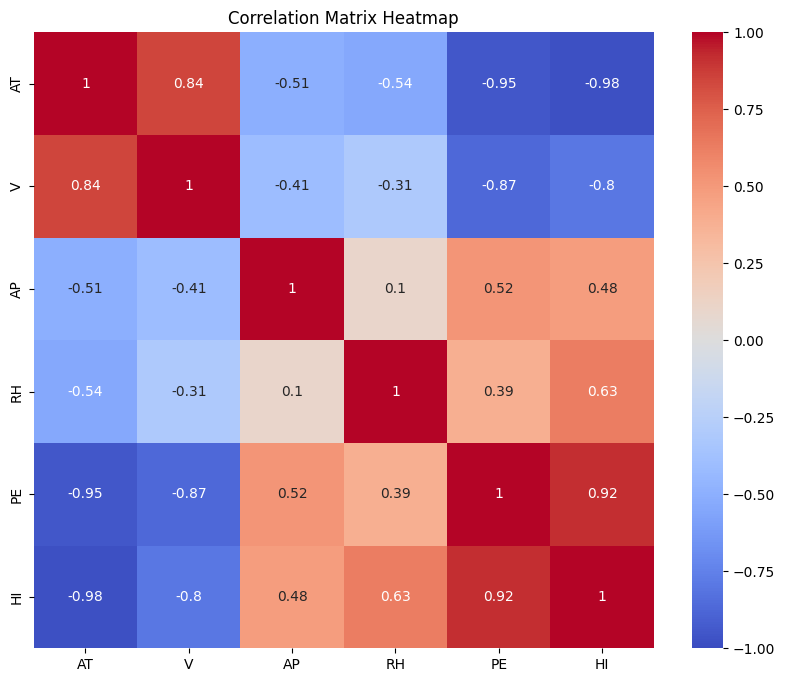

In [4]:
# Print data analysis
du.analyse_dataset(data)

Clean and normalize the data and print the description of the normalized data
The analysis of the data show that the dataset is clean and dows not necessitate of any removal of rows.

In [5]:
data = du.clean_data(data)

# Select features to normalize
features = ['AT', 'AP', 'RH', 'V', 'HI']
data = du.normalize_data(data, features)

print(data.describe())

Null values in each column:
 AT    0
V     0
AP    0
RH    0
PE    0
HI    0
dtype: int64

Check DataTypes
AT    float64
V     float64
AP    float64
RH    float64
PE    float64
HI    float64
dtype: object

Invalid Temperature values:
 Empty DataFrame
Columns: [AT, V, AP, RH, PE, HI]
Index: []

Invalid Ambient Pressure values:
 Empty DataFrame
Columns: [AT, V, AP, RH, PE, HI]
Index: []

Invalid Relative Humidity values:
 Empty DataFrame
Columns: [AT, V, AP, RH, PE, HI]
Index: []

Invalid Exhaust Vacuum values:
 Empty DataFrame
Columns: [AT, V, AP, RH, PE, HI]
Index: []

Data after removing invalid rows:
          AT      V       AP     RH      PE          HI
0     14.96  41.76  1024.07  73.17  463.26  275.468466
1     25.18  62.96  1020.04  59.08  444.37  195.034349
2      5.11  39.40  1012.16  92.14  488.56  370.823818
3     20.86  57.32  1010.24  76.64  446.48  233.858195
4     10.82  37.50  1009.23  96.62  473.90  310.199024
...     ...    ...      ...    ...     ...         ...
9563

Split data between train and evaluate set
These set will be used to train and evaluate both models: linear regression and randem forest

In [6]:
# Split data between train and evaluate set
X = data[['AT', 'AP', 'RH', 'V', 'HI']]
y = data['PE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55)

Now we train and evaluate the LinearRegression model and make a prediction with the trained model using the y dataset created previously. 
We will also print a diagram of the residuals (id est Actual versus Predicted values).

Linear Regression Elapsed Training Time: 0.007441997528076172
Linear Regression Measured Prediction Time: 0.004004955291748047
Linear Regression Cross-Validation MSE: 19.51
Linear Regression Cross-Validation RMSE: 4.42
Linear Regression Cross-Validation R²: 0.93


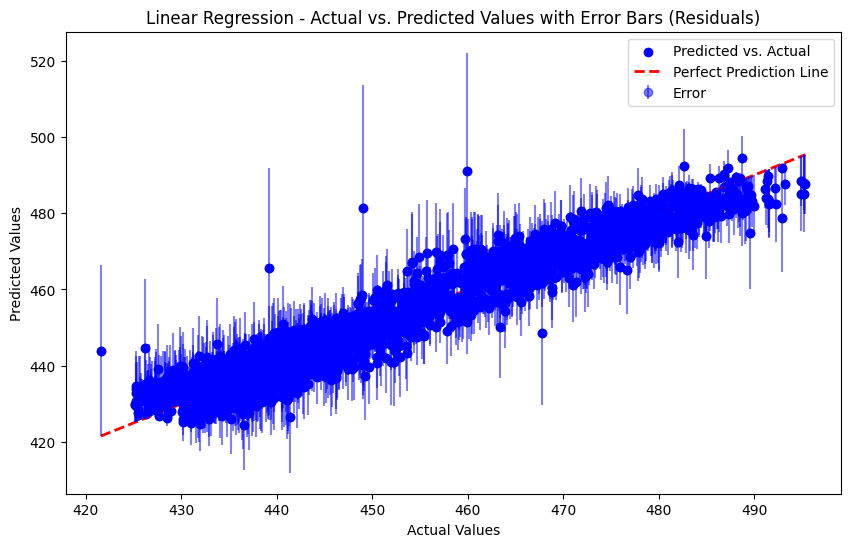

In [7]:
############## TRAIN and EVALUATE LINEAR REGRESSION MODEL ##############
start_time = time.time()
# Initialize the Linear Regression model
lr_model = LinearRegression()
# Train the model
lr_model.fit(X_train, y_train)
train_time_lr = time.time() - start_time

# Make predictions on the test set
start_time = time.time()
y_pred = lr_model.predict(X_test)
pred_time_lr = time.time() - start_time

# Evaluate Model
lr_mean_cv_mse, lr_mean_cv_rmse, lr_mean_cv_r2 = mu.evaluate_model(y_test,y_pred)

print(f"Linear Regression Elapsed Training Time: {train_time_lr}")
print(f"Linear Regression Measured Prediction Time: {pred_time_lr}")

print(f"Linear Regression Cross-Validation MSE: {lr_mean_cv_mse:.2f}")
print(f"Linear Regression Cross-Validation RMSE: {lr_mean_cv_rmse:.2f}")
print(f"Linear Regression Cross-Validation R²: {lr_mean_cv_r2:.2f}")
mu.chart_predictions(y_test,y_pred, 'Linear Regression - Actual vs. Predicted Values with Error Bars (Residuals)')

The linear Regression model is very fast (0.007 seconds) and performs very well
Cross-Validation MSE: 19.51
Cross-Validation RMSE: 4.42
Cross-Validation R²: 0.93

Meaning that correctly predicts 93% of the test values, with relativly low errors.

Now we do the same with a RandomForest model:
train and evaluate the model 
make a prediction with the trained model using the y dataset created previously
print a diagram of the residuals (id est Actual versus Predicted values).

RandomForest Regression Elapsed Training Time: 7.527337074279785
RandomForest Regression Measured Prediction Time: 0.11873626708984375
RandomForest Regression Cross-Validation MSE: 11.61
RandomForest Regression Cross-Validation RMSE: 3.41
RandomForest Regression Cross-Validation R²: 0.96


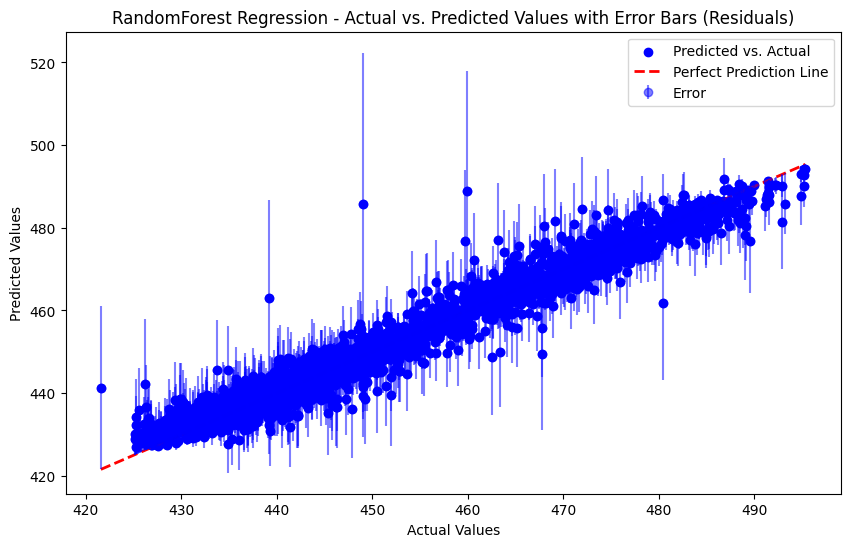

In [8]:
############## TRAIN and EVALUATE RANDOM FOREST MODEL ##############
start_time = time.time()
# Initialize the Random Forest model
rf_model = RandomForestRegressor()  #(n_estimators=100, random_state=55)
# Train the model
rf_model.fit(X_train, y_train)
train_time_rf = time.time() - start_time

# Make predictions on the test set
start_time = time.time()
y_pred = rf_model.predict(X_test)
pred_time_rf = time.time() - start_time

# Evaluate Model
rf_mean_cv_mse, rf_mean_cv_rmse, rf_mean_cv_r2 = mu.evaluate_model(y_test, y_pred)

print(f"RandomForest Regression Elapsed Training Time: {train_time_rf}")
print(f"RandomForest Regression Measured Prediction Time: {pred_time_rf}")

print(f"RandomForest Regression Cross-Validation MSE: {rf_mean_cv_mse:.2f}")
print(f"RandomForest Regression Cross-Validation RMSE: {rf_mean_cv_rmse:.2f}")
print(f"RandomForest Regression Cross-Validation R²: {rf_mean_cv_r2:.2f}")
mu.chart_predictions(y_test,y_pred, 'RandomForest Regression - Actual vs. Predicted Values with Error Bars (Residuals)')

We see that the RandomForest model is definitely slower (7.5 seconds) but also has a MSE that is almost the half and a R-squared value that indicates 3% more of correct predictions (96%).

Given the fact that is some 1.4K times slower, a careful evaluation needs to be done, if the 3% prediction increase is sufficient for justifying the addditional computational costs.

See also the comparison of the models.

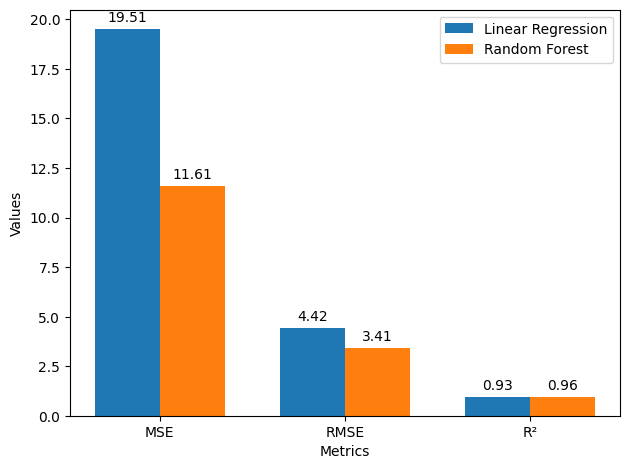

In [9]:
##### Compare LinearRegression and RandmForest models ######
mu.visualize_results(lr_mean_cv_mse, lr_mean_cv_rmse, lr_mean_cv_r2, rf_mean_cv_mse, rf_mean_cv_rmse, rf_mean_cv_r2)

Given that there is not a big difference between a LinearRegression and a RandomForest model, let's analyse an Ordinary Least Squares (OLS).
OLS is a method used in linear regression to estimate the parameters of the model. The OLS method aims to find the best-fitting line by minimizing the sum of the squared differences between the observed values and the values predicted by the linear model.
Key Points about OLS:
Objective: Minimize the sum of the squared residuals (differences between observed and predicted values).
Model: A linear relationship between the dependent variable (target) and one or more independent variables (predictors).
Parameters: Estimates the coefficients (weights) for the predictors and the intercept.



                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                 2.663e+04
Date:                Tue, 15 Oct 2024   Prob (F-statistic):               0.00
Time:                        17:36:30   Log-Likelihood:                -27790.
No. Observations:                9568   AIC:                         5.559e+04
Df Residuals:                    9562   BIC:                         5.564e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        474.2273      1.225    387.065      0

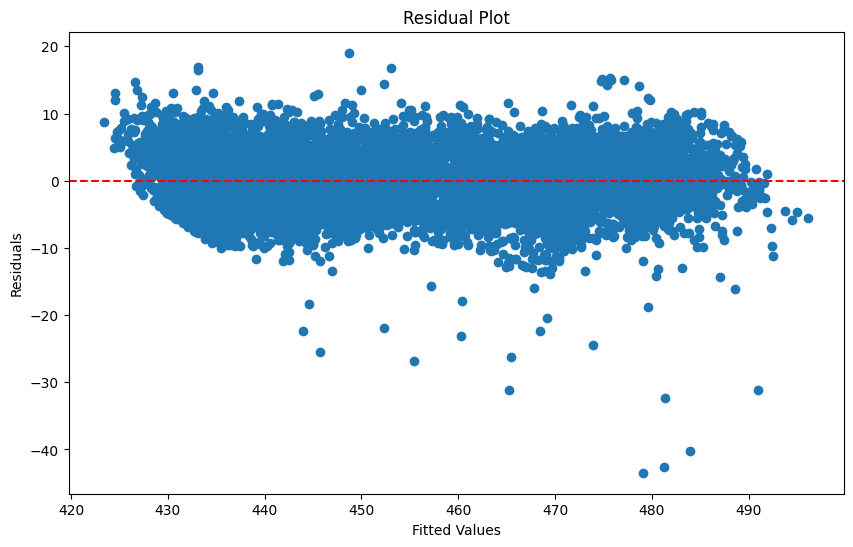

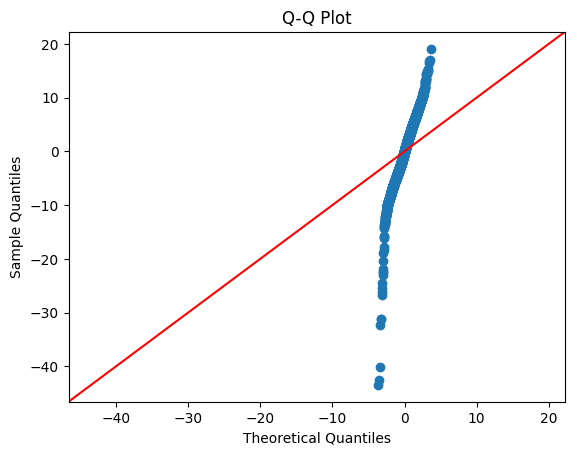

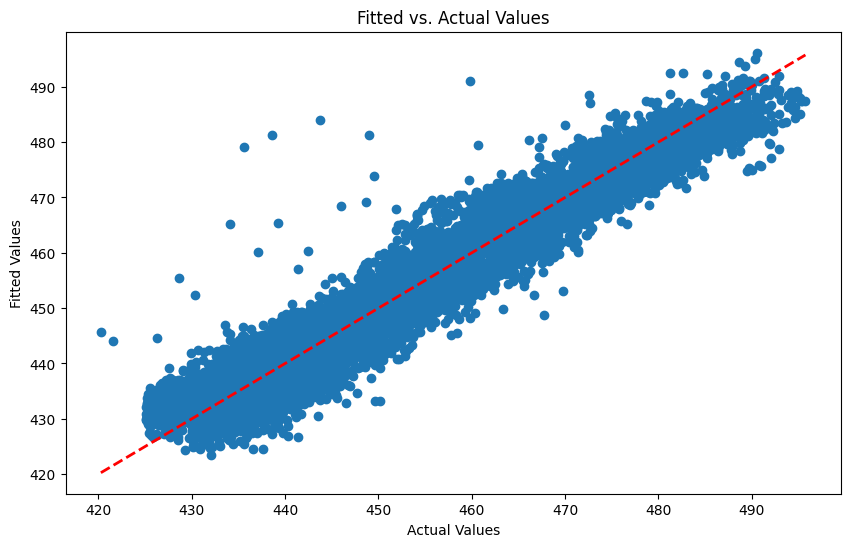


                    PE    
--------------------------
const          474.2273***
               (1.2252)   
AT             -39.0902***
               (1.3451)   
AP             2.3417***  
               (0.3706)   
RH             -16.3332***
               (0.3528)   
V              -14.3003***
               (0.3995)   
HI             34.8349*** 
               (1.4053)   
R-squared      0.9330     
R-squared Adj. 0.9330     
Standard errors in
parentheses.
* p<.1, ** p<.05, ***p<.01


,AT,V,AP,RH,PE,HI
0,0.372521,0.291815,0.771591,0.638204,463.260000,0.592143
1,0.662040,0.669039,0.671863,0.449330,444.370000,0.319329
2,0.093484,0.249822,0.476862,0.892493,488.560000,0.915568
3,0.539660,0.568683,0.429349,0.684718,446.480000,0.451011
4,0.255241,0.216014,0.404355,0.952547,473.900000,0.709942


In [13]:
ols.evaluate_ols(X,y)

R-squared: 0.933: This indicates that the model explains 93.3% of the variance in the dependent variable. In other words, the independent variables do a good job of predicting the target.
Adj. R-squared: 0.933: The Adjusted R-squared also accounts for the number of predictors in the model. A high Adjusted R-squared value close to the R-squared value signifies that the model is a good fit and isn’t unnecessarily complex.
F-statistic: 2.663e+04: The F-statistic measures the overall significance of the model. A large F-statistic indicates that the independent variables collectively have a significant impact on the dependent variable.
Prob (F-statistic): 0.00: This is the p-value associated with the F-statistic. A value of 0.00 means that there is virtually no chance that the observed F-statistic is due to random chance, hence the model is statistically significant.
Log-Likelihood: -27790: The log-likelihood value reflects the goodness of fit of the model; higher values (closer to zero) indicate a better fit. In isolation, it’s hard to interpret, but it helps in comparing models. 

Overall, these results suggest that the OSL model is highly significant and does an excellent job explaining the variation in the dependent variable.